In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
import itertools
import warnings
warnings.filterwarnings('ignore')


In [136]:
data = pd.read_csv(r'''C:\Users\solov\DZ46/cardox.csv''')
data.head()

,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86


In [137]:
data.index = pd.to_datetime(data['date'], format = '%Y%m%')

In [138]:
del data['date']

In [139]:
data.tail()

,value
date,
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51
2018-10-01,406.00
2018-11-01,408.02


<AxesSubplot:xlabel='date'>

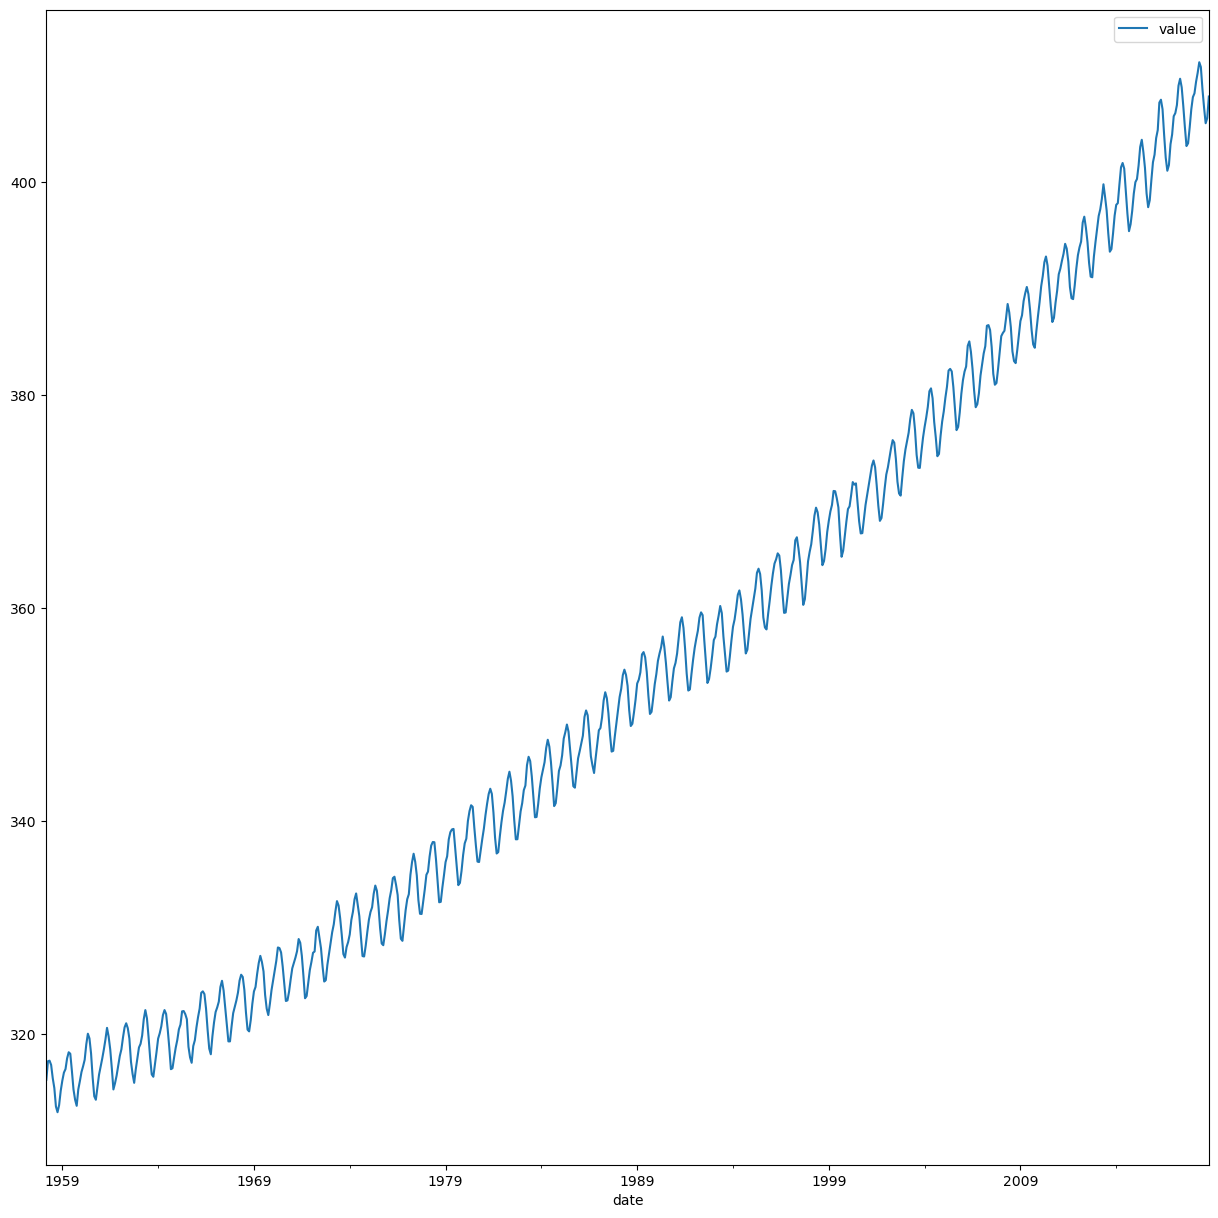

In [140]:
data.plot()

In [141]:
data.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


In [142]:
data.isna().sum()

value    0
dtype: int64

In [143]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.show()

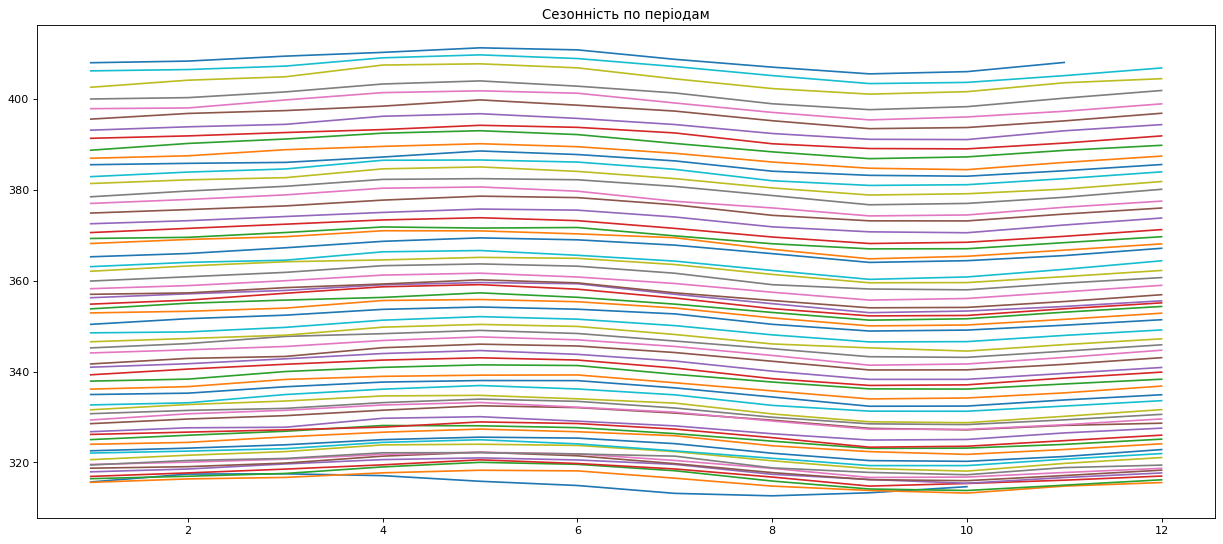

In [144]:
sesonal(data, 12)

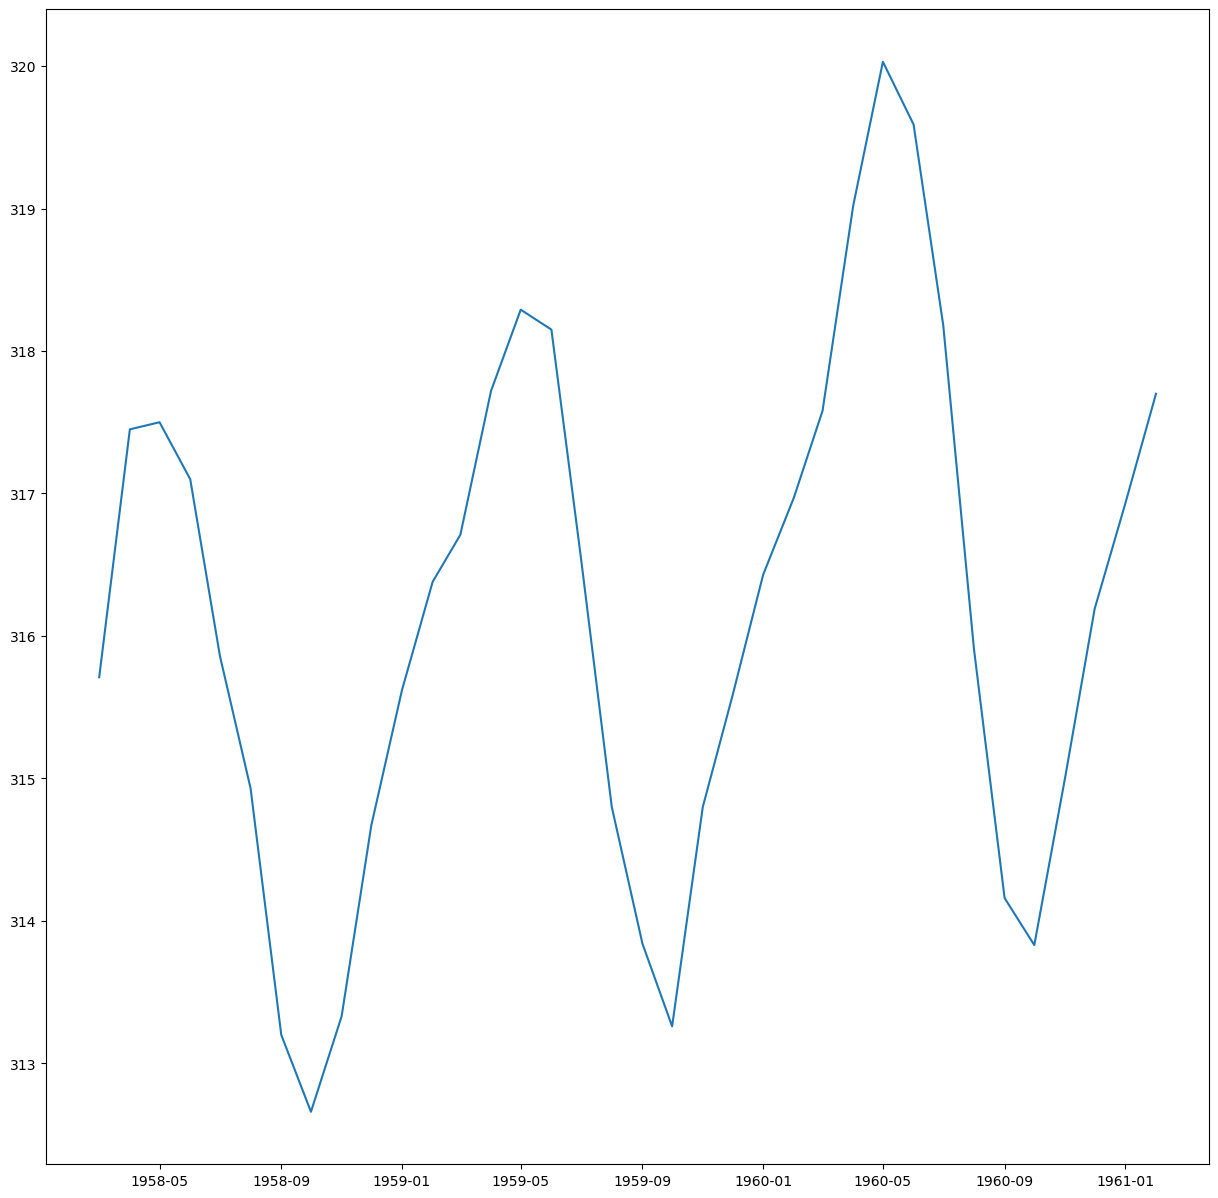

In [145]:
plt.plot(data[:36])

In [146]:
decompose = seasonal_decompose(data, model = 'additive', extrapolate_trend=12)

Text(0.5, 0.98, 'additive model')

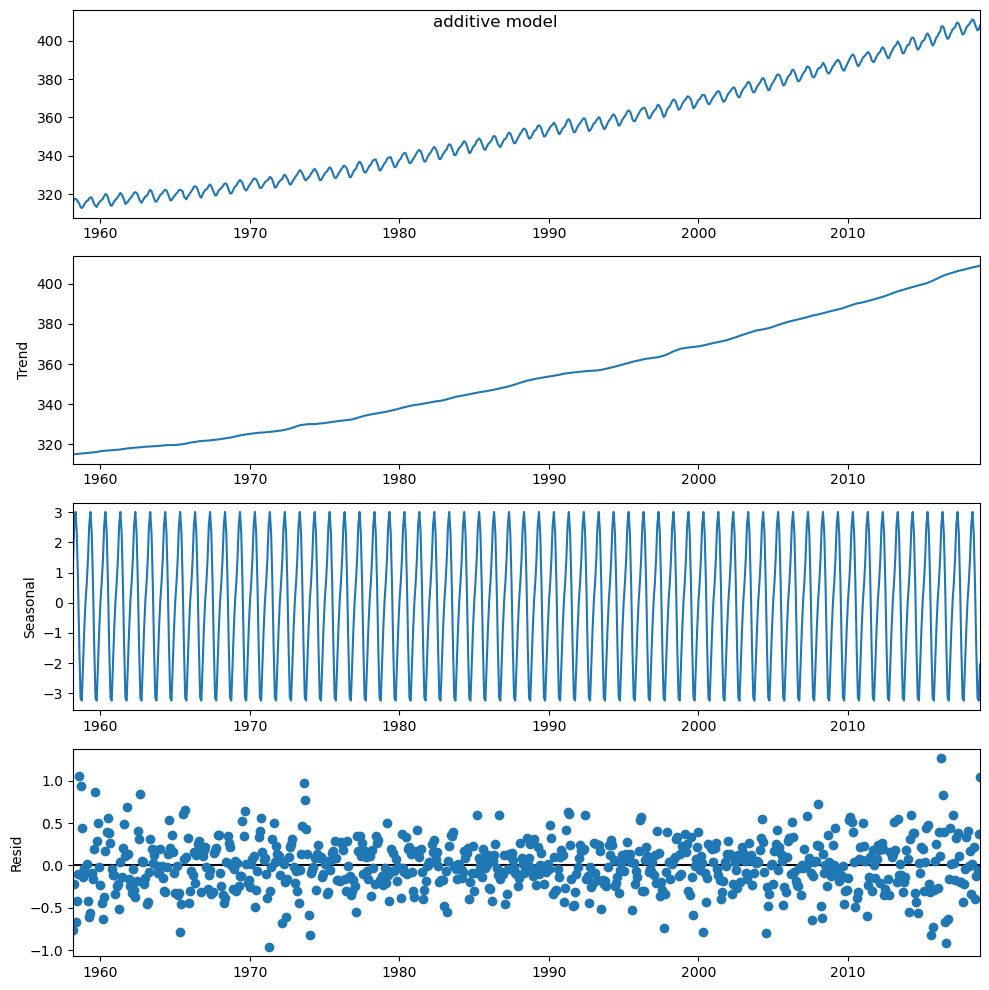

In [147]:
plt.rcParams.update({'figure.figsize': (10,10)})
decompose.plot().suptitle('additive model')

In [148]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean() 
    rolstd = timeseries.rolling(window=12).std() 
    plt.rcParams["figure.figsize"] = (15,15)
    plt.plot(timeseries, color = 'green', label = 'true data')
    plt.plot(rolmean, color = 'red', label = 'rolling mean')
    plt.plot(rolstd, color = 'black', label = 'std')
    plt.show()

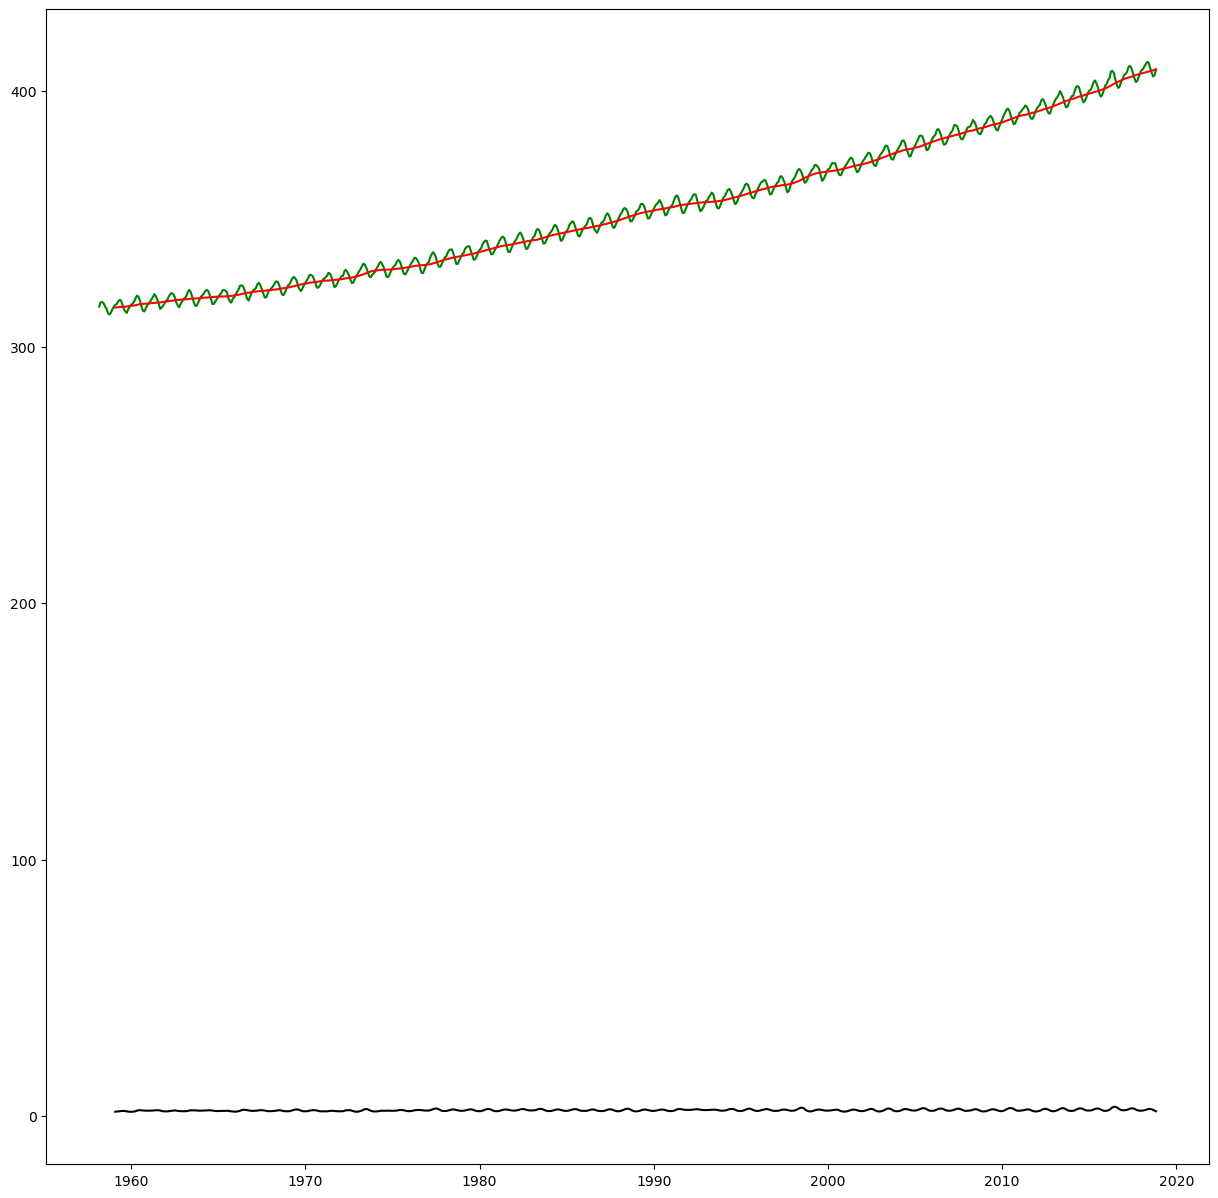

In [149]:
test_stationarity(data)

In [150]:
def test_s(data):
    test_stat = adfuller(data)
    if test_stat[0] < test_stat[4]['10%']:
        print(f"p-value {test_stat[1]}, critical values: {test_stat[4]},\n stationary time series")
    else:
        print(f"p-value {test_stat[1]}, critical values: {test_stat[4]}, \n NOT stationary time series")

In [151]:
test_s(data)

p-value 1.0, critical values: {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}, 
 NOT stationary time series


In [152]:
train_data = data[:-20]
test_data = data[-20:]

In [153]:
fit_expo = HWES(train_data, seasonal_periods=12, trend = 'add', seasonal='add')

In [154]:
fitted = fit_expo.fit()

In [155]:
print(fitted.summary().tables[1])

                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5647667                alpha                 True
smoothing_trend               0.0132984                 beta                 True
smoothing_seasonal            0.1059750                gamma                 True
initial_level                 314.66280                  l.0                 True
initial_trend                 0.0769197                  b.0                 True
initial_seasons.0             1.1361694                  s.0                 True
initial_seasons.1             2.2321442                  s.1                 True
initial_seasons.2             2.6281982                  s.2                 True
initial_seasons.3             2.0403681                  s.3                 True
initial_seasons.4             0.6241941                  s.4                 True
initial_seasons.

In [156]:
sales_forecast = fitted.forecast(steps=20)

In [157]:
date_range = pd.date_range(train_data.index[-1], periods = 380, freq = 'M')

In [158]:
sales_forecast_new = fitted.forecast(steps=len(date_range))

In [159]:
d = {'predict':sales_forecast_new}
predicted_data = pd.DataFrame(data = d)

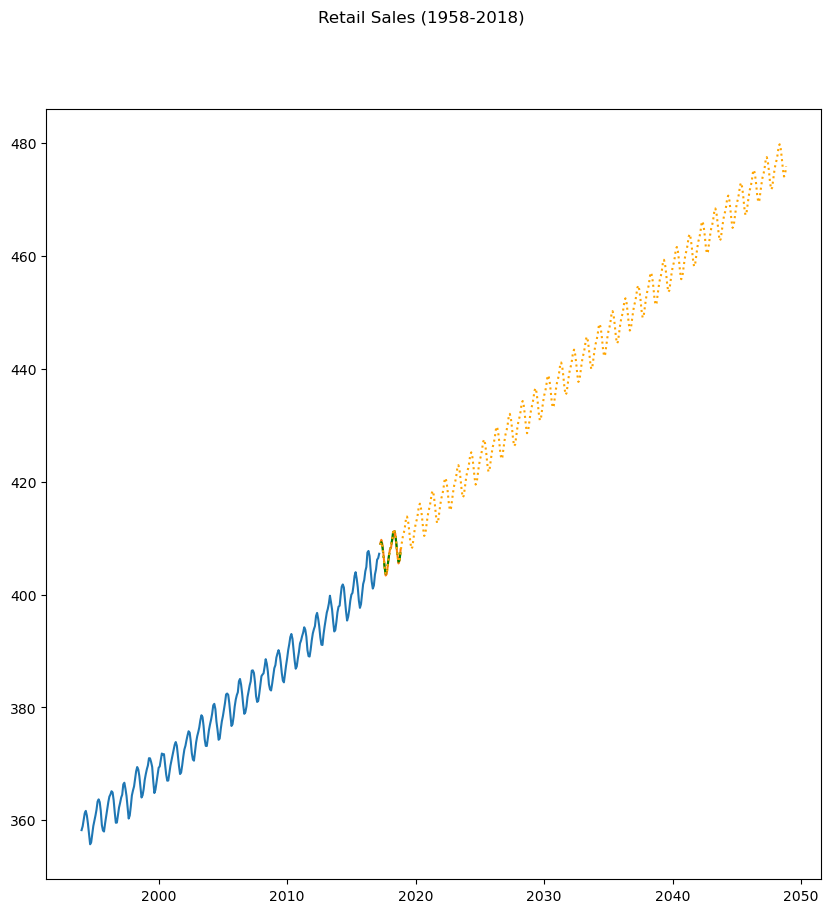

In [160]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Retail Sales (1958-2018)')
past = plt.plot(train_data.index[430:], train_data[430:], label='Sales History')
future = plt.plot(test_data.index, test_data)
predicted_test = plt.plot(test_data.index, sales_forecast, linestyle='-.', color = 'green')
predicted_values = plt.plot(predicted_data.index, sales_forecast_new, color = 'orange', linestyle=':')
plt.show()

In [161]:
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [162]:
metrics(test_data, sales_forecast)

Тест на стаціонарність:
	T-статистика = -0.051
	P-значення = 0.954
Критичне значення :
	1%: -4.223238279489106 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.189368925619835 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.729839421487603 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 0.2757
MSE: 0.1065
MAPE: 0.0007
MPE: -0.0002
Стандартна похибка: 0.3263


In [163]:
from pmdarima.arima import auto_arima

In [92]:
arima_model = auto_arima(train_data, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=451.986, Time=14.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2299.251, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=4.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1567.080, Time=2.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2305.104, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=13.12 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=743.343, Time=13.68 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=452.344, Time=39.72 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1396.151, Time=2.55 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=29.81 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=587.192, Time=32.03 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=474.045, Time=43.14 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=444.685, Time=13.79 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   :

In [164]:
model_sarima = sm.tsa.statespace.SARIMAX(train_data, order=(2, 1, 1), seasonal_order=(1, 0, 1, 12))

In [165]:
result_sarima = model_sarima.fit()

In [166]:
print(result_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3713      0.050      7.418      0.000       0.273       0.469
ar.L2          0.1014      0.035      2.900      0.004       0.033       0.170
ma.L1         -0.7356      0.055    -13.339      0.000      -0.844      -0.627
ar.S.L12       0.9995      0.000   2537.753      0.000       0.999       1.000
ma.S.L12      -0.8666      0.023    -37.647      0.000      -0.912      -0.821
sigma2         0.0969      0.005     20.637      0.000       0.088       0.106


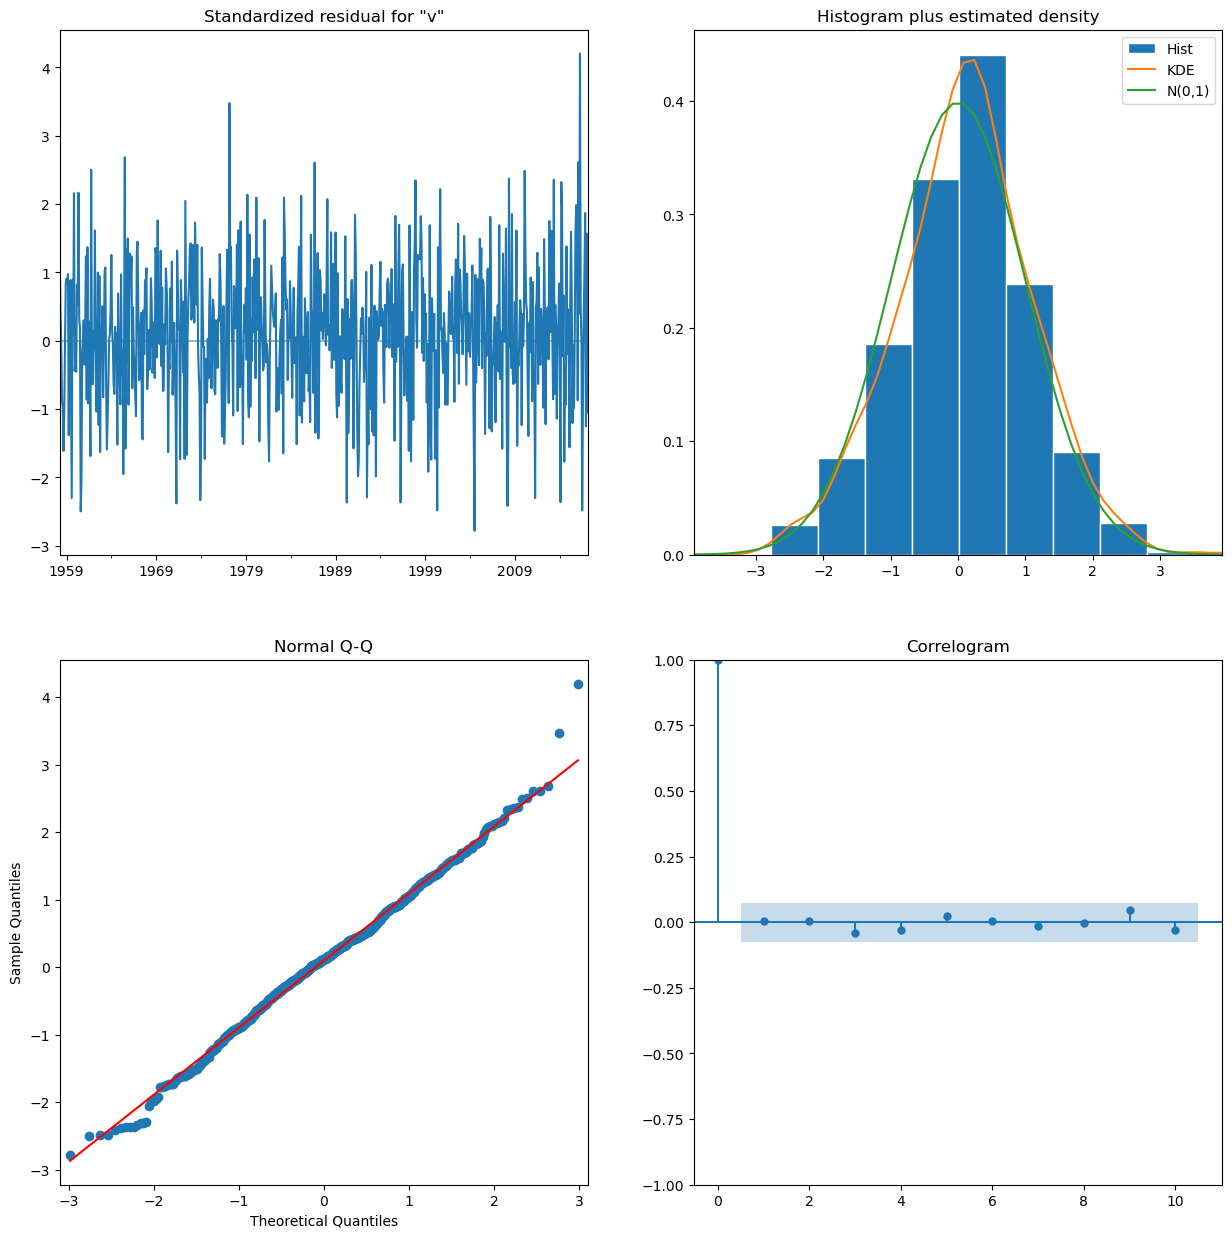

In [167]:
result_sarima.plot_diagnostics()
plt.show()

In [168]:
predicted = result_sarima.predict()
pred = result_sarima.get_prediction()
pred_df = pred.summary_frame()

In [169]:
pred_df.head()

value,mean,mean_se,mean_ci_lower,mean_ci_upper
1958-03-01,0.000000,1000.001083,-1959.966107,1959.966107
1958-04-01,315.709790,1.471725,312.825261,318.594319
1958-05-01,316.915484,1.400584,314.170391,319.660578
1958-06-01,317.276605,1.390718,314.550848,320.002361
1958-07-01,317.083220,1.385481,314.367727,319.798714


In [170]:
test_data.head()

,value
date,
2017-04-01,409.04
2017-05-01,409.69
2017-06-01,408.88
2017-07-01,407.12
2017-08-01,405.13


In [171]:
predict_new = result_sarima.get_prediction(start="2018", end="2048")

In [175]:
predict_test = result_sarima.get_prediction(start='2017-04', end='2018-11')

In [176]:
metrics(test_data, predict_test.predicted_mean)

Тест на стаціонарність:
	T-статистика = -2.149
	P-значення = 0.225
Критичне значення :
	1%: -4.223238279489106 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.189368925619835 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.729839421487603 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 0.2476
MSE: 0.1004
MAPE: 0.0006
MPE: -0.0002
Стандартна похибка: 0.3169


In [177]:
predict_new.predicted_mean

2018-01-01    407.924923
2018-02-01    408.670145
2018-03-01    409.574388
2018-04-01    411.099668
2018-05-01    411.696852
                 ...    
2047-09-01    470.327001
2047-10-01    470.594674
2047-11-01    472.112168
2047-12-01    473.516664
2048-01-01    474.700312
Freq: MS, Name: predicted_mean, Length: 361, dtype: float64

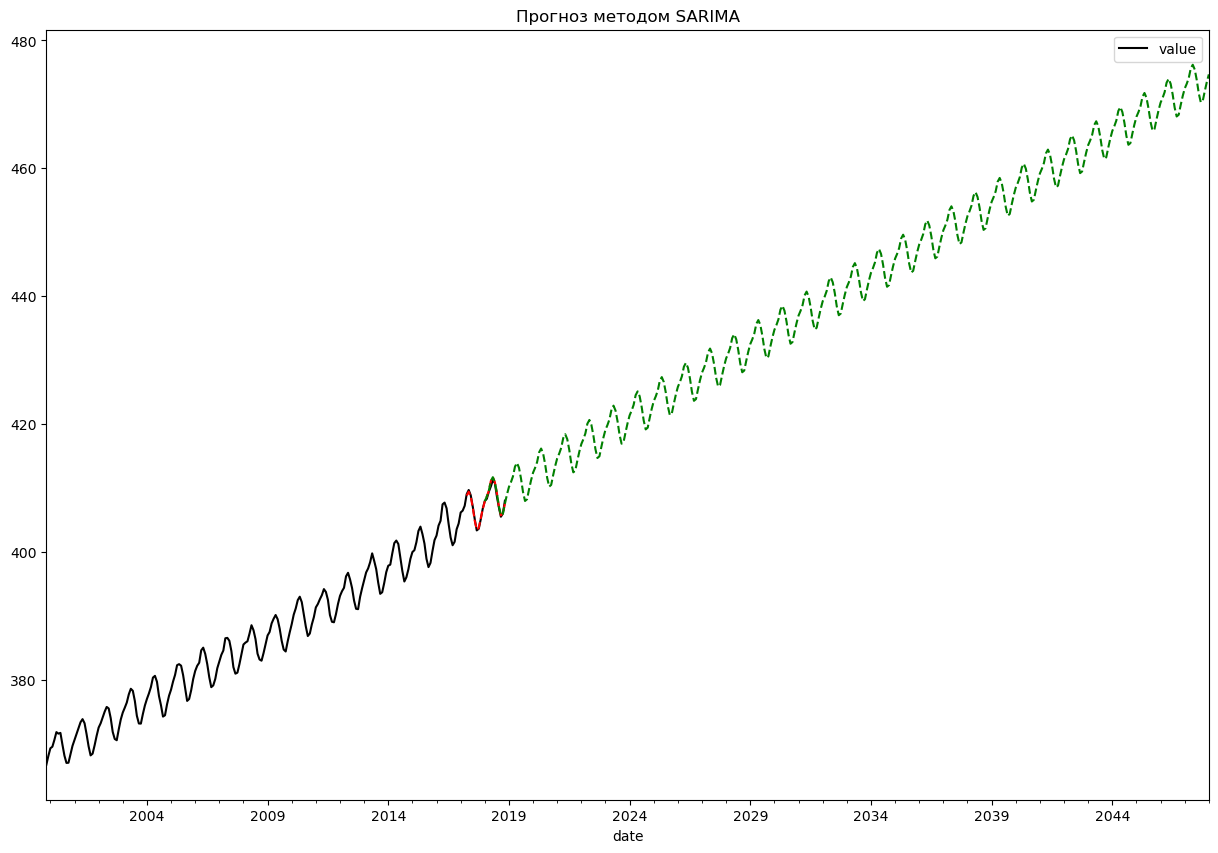

In [178]:
ax = data[500:].plot(figsize=(15,10), color='black', title="Прогноз методом SARIMA" )
predict_test.predicted_mean.plot(ax=ax, style='--', color='red')
predict_new.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [179]:
forecast_d = {'predict' : predict_new.predicted_mean}
forecast_df = pd.DataFrame(data = forecast_d)

In [187]:
from pathlib import Path  
path = Path('C:/Users/solov/DZ46/forecast_shop.csv')

forecast_df.to_csv(path)

In [109]:
!pip install statsmodels


In [113]:
!pip install pandas

In [114]:
!pip install numpy